In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy
import scipy.stats
import math
from scipy.interpolate import make_interp_spline, BSpline


In [2]:
def adjust_qr(rx, rp, rz):
    
    rz_new, rp_new = np.unique(rx, return_counts=True)
    rp_new = rp_new * rp[0]
    #rz_new= np.arange(0, len(rp_new), 1)
    
    return rx, rp_new, rz_new

In [3]:
def VaR(z, p, lim):
    var = 0
    cum_p = 0
    for j, atom in enumerate(p):
        cum_p += atom
        if cum_p>= lim:
            var = z[j]
            break
    return var

def CVaR (z, p, var, lim):
    cvar = var
    expected_c = 0 
    for i, j in enumerate(p):
        if p[i] > 0:
            expected_c += j * max(0, z[i]-var)
    cvar+= 1/(1- alpha) * expected_c
    return cvar

def variance(z, p):
    average = np.average(z, weights=p)
    variance = np.average((z-average)**2, weights=p)
    return variance

def weighted_mean(z,p):
    return np.average(z, weights=p)

def prob_threshold(z, p, thresh):
    cum_p = 0
    for j, atom in enumerate(p):        
        if z[j]>= thresh:
            cum_p += atom
            
    return cum_p

In [4]:
def l2 (u_values, v_values, u_weights=None, v_weights=None, debug=False):
    u_values = np.asarray(u_values, dtype=float)
    v_values = np.asarray(v_values, dtype=float)
    u_weights = np.asarray(u_weights, dtype=float)
    v_weights = np.asarray(v_weights, dtype=float)
    
    u_sorter = np.argsort(u_values)
    v_sorter = np.argsort(v_values)

    all_values = np.concatenate((u_values, v_values))
    all_values.sort(kind='mergesort')

    # Compute the differences between pairs of successive values of u and v.
    deltas = np.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1], 'right')
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1], 'right')

    # Calculate the CDFs of u and v using their weights
    u_sorted_cumweights = np.concatenate(([0],np.cumsum(u_weights[u_sorter])))
    u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    v_sorted_cumweights = np.concatenate(([0],np.cumsum(v_weights[v_sorter])))
    v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]
    
    if debug:
        print("delta", deltas)
        print("cdf u:", u_cdf)
        print("cdf v:", v_cdf)
        print("square cdf u - cdf v", np.square(u_cdf - v_cdf))
        print("square diff * delta", np.multiply(np.square(u_cdf - v_cdf), deltas))
        print("sum( (square diff) *delta))", np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))
    return np.sqrt(np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))


## Graphs

##### DTMC

In [5]:
def dtmc_compute(idx, apdx, experiment_name, rep_type, show_graph=True, debug=True, print_metrics=False, shaded=False, y_level=0.3, y_padding=0.3, alpha=0.7):
    if debug:
        print('Reading file: '+file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+apdx+'.csv')
    dist = pd.read_csv(file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+apdx+'.csv')
    #dist.head(10)
    rx = dist['r'].to_numpy()
    rp = dist['p'].to_numpy()
    n = np.max(np.where(rp > 1e-20))
    rx = rx[0:n+1]
    rp = rp[0:n+1]

    var_dtmc = VaR(rx, rp, alpha)
    metrics = np.array([weighted_mean(rx, rp), variance(rx, rp), var_dtmc, CVaR(rx, rp, var_dtmc, alpha), prob_threshold(rx, rp, thresh)])
    # z = z[0:n+1]
    if debug:
        print(n)
        print(np.sum(rp), np.allclose(np.sum(rp), 1))
        print("max p:", np.max(rp))
    
    distr = scipy.stats.rv_discrete(values=(rx, rp))
    if show_graph:
        # h = plt.bar(rx, rp, alpha=0.5)
        fig = plt.figure(figsize=fig_size)

        if shaded:
            # plt.bar(rx, distr.pmf(rx), width=0.98, color='gray', alpha=0.45, linewidth=0,label='PDF')
            kernel = scipy.stats.gaussian_kde(rx, weights=rp)
            range = np.arange(0, n, 1)
            # plt.plot(range, kernel(range), label='gaussian PDF')
            # 300 represents number of points to make between T.min and T.max
            xnew = np.linspace(6, rx.max(), 300) 

            spl = make_interp_spline(rx, distr.pmf(rx), k=3)  # type: BSpline
            power_smooth = spl(xnew)
            idx_start = (np.abs(xnew - metrics[2])).argmin()
            plt.plot(xnew, power_smooth, color='k', alpha=0.8, label='Smoothed PDF')
            
            plt.fill_between(xnew[idx_start:], power_smooth[idx_start:], 0, color='gray', alpha=.6)
            
            plt.vlines(x=[metrics[0], metrics[2], metrics[3]], linestyles='dashed', ymin=0, ymax=1, color = 'k')
            
            plt.text(metrics[0]+y_padding, y_level+0.15, r'$\mathbb{E}$', fontsize=graphsize-10,  rotation=90, verticalalignment='center')
            plt.text(metrics[2]-y_padding-1.5, y_level, r'$\mathsf{VaR}_{'+str(alpha)+r'}$', fontsize=graphsize-10, rotation=90, verticalalignment='center')
            plt.text(metrics[3]+y_padding, y_level, r'$\mathsf{CVaR}_{'+str(alpha)+r'}$', fontsize=graphsize-10, rotation=90, verticalalignment='center')

        else:
            if (xmax-xmin)>400:
                h = plt.bar(rx, distr.pmf(rx), width=1, alpha=0.5, label='PDF')
            else:
                h = plt.bar(rx, distr.pmf(rx), alpha=0.5, label='PDF')
            kernel = scipy.stats.gaussian_kde(rx, weights=rp)
            range = np.arange(0, n, 0.1)
            plt.plot(range, kernel(range), label='Smoothed PDF')
        plt.xlim([xmin,xmax])
        plt.ylim([0,ymax])

        if not shaded:
            plt.legend(loc='upper right', fontsize=graphsize-10)
        plt.tick_params(axis='both', which='major', labelsize=graphsize-15)
        plt.ticklabel_format(axis='both')
        plt.xlabel('Value', fontsize=graphsize-10)
        plt.ylabel('Probability', fontsize=graphsize-10)
        # plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
        plt.tight_layout()
        plt.show()
    # plt.fill_between(range, kernel(range))

    if save_graphs:
        print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+apdx+".png")
        fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+apdx+".png", transparent=True, dpi=400)

    if debug or print_metrics:
        print("DTMC for",alg_type, " E:", weighted_mean(rx, rp),", variance:",variance(rx, rp),", VaR:",var_dtmc,", CVaR:", CVaR(rx, rp, var_dtmc, alpha),", Threshold:",prob_threshold(rx, rp, thresh))
    return rx,rp, metrics, distr

##### Expected Value Iteration

In [6]:
def exp_compute(idx, apdx, experiment_name, rep_type, show_graph=True, debug=True, print_metrics=False, elements=False, figure = None, smooth=False, alpha=0.7):
    if debug:
        print('Reading file: '+file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+'.csv')
    dist = pd.read_csv(file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+'.csv')
    #dist.head(10)
    rx_e = dist['r'].to_numpy()
    rp_e = dist['p'].to_numpy()
    z_e = dist['z'].to_numpy()
    if 'qr' in rep_type:
        if debug:
            print('converting distribution from qr')
        rx_e, rp_e, z_e = adjust_qr(rx_e, rp_e, z_e)
        # print(len(rx_e), rx_e)
        # print(len(rp_e), rp_e)
        # print(len(z_e), z_e)

    n = np.max(np.where(rp_e > 1e-8))
    rx_e = rx_e[0:n+1]
    rp_e = rp_e[0:n+1]
    z_e = z_e[0:n+1]
    
    if debug:
        print(len(dist.index))
        print(np.sum(rp_e), np.allclose(np.sum(rp_e), 1))
        print("max p:", np.max(rp_e))
    
    if show_graph:
        distr_e = scipy.stats.rv_discrete(values=(z_e, rp_e))
        # h = plt.bar(rx_e, rp_e, alpha=0.5)
        fig=plt.figure(figsize=fig_size)
        
        if not elements:
            h = plt.bar(z_e, rp_e, alpha=0.5, color='g', label='PDF')
        else:
            h = plt.bar(z_e, rp_e, alpha=0.8, width=0.3, color='g')
            plt.plot(z_e, rp_e, 'go')
            if not smooth:
                plt.bar(figure[0], figure[1].pmf(figure[0]), width=0.98, color='k', alpha=0.3, linewidth=0,label='PDF')
            else:
                # 30`0 represents number of points to make between T.min and T.max
                xnew = np.linspace(6, figure[0].max(), 300) 

                spl = make_interp_spline(figure[0], figure[1].pmf(figure[0]), k=3)  # type: BSpline
                power_smooth = spl(xnew)

                plt.plot(xnew, power_smooth, color='k', alpha=0.5, label='Smoothed PDF')
                plt.fill_between(xnew, power_smooth, 0, color='gray', alpha=.3)
        kernel = scipy.stats.gaussian_kde(z_e, weights=rp_e)
        if 'qr' in rep_type:
            range = z_e
        else:
            range = np.arange(0, z_e[-1]+z_e[1], z_e[1])

        if not elements:
            plt.plot(range, kernel(z_e), color='g', label='Smoothed PDF')
        
        plt.xlim([xmin,xmax])
        plt.ylim([0,ymax])

        if not elements:
            plt.legend(loc='upper right', fontsize=graphsize-10)

        plt.tick_params(axis='both', which='major', labelsize=graphsize-15)
        plt.ticklabel_format(axis='both')
        plt.xlabel('Value', fontsize=graphsize-10)
        plt.ylabel('Probability', fontsize=graphsize-10)
        # plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
        plt.tight_layout()
        plt.show()
    # plt.fill_between(range, kernel(range))

        if save_graphs:
            if not smooth:
                print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+".png")
                fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+".png", transparent=True, dpi=400)
            else:
                print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+'_smooth'+".png")
                fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+'_smooth'+".png", transparent=True, dpi=400)
                
    
    var_exp = VaR(z_e, rp_e, alpha)
    if debug or print_metrics:
        print(f"Risk neutral DVI: E:{weighted_mean(z_e, rp_e)}, variance:{variance(z_e, rp_e)}, VaR:{var_exp}, CVaR:{CVaR(z_e, rp_e, var_exp, alpha)}, threshold:{prob_threshold(z_e, rp_e, thresh)}")
    return z_e, rp_e, np.array([weighted_mean(z_e, rp_e), variance(z_e, rp_e), var_exp, CVaR(z_e, rp_e, var_exp, alpha), prob_threshold(z_e, rp_e, thresh)])

##### CVaR

In [7]:
def cvar_compute(idx, apdx, experiment_name, rep_type, show_graph=True, debug=True, print_metrics=False, elements=False, figure=None, smooth =False, alpha=0.7):
    if debug:
        print('Reading file: '+file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+'.csv')
    dist = pd.read_csv(file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+'.csv')
    #dist.head(10)
    rx_c = dist['r'].to_numpy()
    rp_c = dist['p'].to_numpy()
    z_c = dist['z'].to_numpy()
    if 'qr' in rep_type:
        if debug:
            print('converting distribution from qr')
        rx_c, rp_c, z_c = adjust_qr(rx_c, rp_c, z_c)
    n = np.max(np.where(rp_c > 1e-6))
    rx_c = rx_c[0:n+1]
    rp_c = rp_c[0:n+1]
    z_c = z_c[0:n+1]
    if debug:
        print(n)
        print(np.sum(rp_c), np.allclose(np.sum(rp_c), 1))
        print("max p:", np.max(rp_c))
    
    if show_graph:
        distr_c = scipy.stats.rv_discrete(values=(z_c, rp_c))
        # h = plt.bar(rx_c, rp_c, alpha=0.5)
        fig=plt.figure(figsize=fig_size)
            
        if not elements:
            h = plt.bar(z_c, rp_c, alpha=0.5, color='g', label='PDF')
        else:
            h = plt.bar(z_c, rp_c, alpha=0.8, width=0.3, color='g')
            plt.plot(z_c, rp_c, 'go')
            if not smooth:
                plt.bar(figure[0], figure[1].pmf(figure[0]), width=0.98, color='k', alpha=0.3, linewidth=0,label='PDF')
            else:
                # 30`0 represents number of points to make between T.min and T.max
                xnew = np.linspace(6, figure[0].max(), 300) 

                spl = make_interp_spline(figure[0], figure[1].pmf(figure[0]), k=3)  # type: BSpline
                power_smooth = spl(xnew)

                plt.plot(xnew, power_smooth, color='k', alpha=0.5, label='Smoothed PDF')
                plt.fill_between(xnew, power_smooth, 0, color='gray', alpha=.3)
        kernel = scipy.stats.gaussian_kde(z_c, weights=rp_c)
        if 'qr' in rep_type:
            range = z_c
        else:
            range = np.arange(0, z_c[-1]+z_c[1], z_c[1]) 
        
        if not elements:
            plt.plot(range, kernel(range), color='g', label='Smoothed PDF')
        plt.xlim([xmin,xmax])
        plt.ylim([0,ymax])

        if not elements:
            plt.legend(loc='upper right', fontsize=graphsize-10)
        plt.tick_params(axis='both', which='major', labelsize=graphsize-15)
        plt.ticklabel_format(axis='both')
        plt.xlabel('Value', fontsize=graphsize-10)
        plt.ylabel('Probability', fontsize=graphsize-10)
        # plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
        plt.tight_layout()
        plt.show()
        # plt.fill_between(range, kernel(range))

        if save_graphs:
           
            if not smooth:
                print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+".png")
                fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+".png", transparent=True, dpi=400)
            else:
                print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+'_smooth'+".png")
                fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+'_smooth'+".png", transparent=True, dpi=400)

    var_cvar = VaR(z_c, rp_c, alpha)
    if debug or print_metrics:
        print(f"Risk sensitive DVI: E:{weighted_mean(z_c, rp_c)}, variance:{variance(z_c, rp_c)}, VaR:{var_cvar}, CVaR:{CVaR(z_c, rp_c, var_cvar, alpha)}, threshold:{prob_threshold(z_c, rp_c, thresh)}")
    return z_c, rp_c, np.array([weighted_mean(z_c, rp_c), variance(z_c, rp_c), var_cvar, CVaR(z_c, rp_c, var_cvar, alpha), prob_threshold(z_c, rp_c, thresh)])

#### Setup

Set the metric parameters and graph parameters in next cell.

In [8]:
# graph figure parameters
xmax = 500
xmin=-1
ymax=0.1
fig_size= (10,5)

Set experiment name and representation type in the following cell.
Make sure to run the experiments using `run_experiments.py` before visualization.

In [24]:
# Graph Formating
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': False,
    #'text.latex.preamble': r'\usepackage{amsfonts}',
    'axes.spines.right':False,
    'axes.spines.top': False
})
# font size in the graph
graphsize = 38
# experiments folder path, does not need changing
file_path = 'tests/experiments/'
# Change this to select the experiment to visualize
experiment_name='drones_15' 
apdx =  [''] 
alg_type = 'cvar' # Used only for the DTMC graph
rep_type = 'c51' # 'qr' or 'c51'
save_graphs = False # if set to true, save the graph to a png file
num_metrics = 5 # exp val, variance, var, cvar, prob>thresh

In [10]:
metrics_dtmc = np.zeros([len(apdx), num_metrics])
metrics_e = np.zeros([len(apdx), num_metrics])
metrics_c = np.zeros([len(apdx), num_metrics])
print_metrics=True

##### Base experiment Visualization
This cell shows the graph for the base experiment for the selected algorithms followed by a set of distributional metrics in the following order:
* Expected Value
* Variance
* Value at Risk(alpha)
* Conditional Value at Risk(alpha)
* Probability of the cost to be greater than a threshold.

['vi', 'exp', 'cvar', 'dtmc'] are the possible options for the DTMC graph (in `algs`)
- 'vi': PRISM VI algorithm for MDP + DTMC method
- 'exp': risk neutral DVI
- 'cvar' : risk sensitive DVI
- 'dtmc': DTMC method run on a DTMC model

---DTMC---
Reading file: tests/experiments/drones_15/drones_15_distr_dtmc_exp_c51.csv
1108
0.9999999999999987 True
max p: 0.01649269811415242


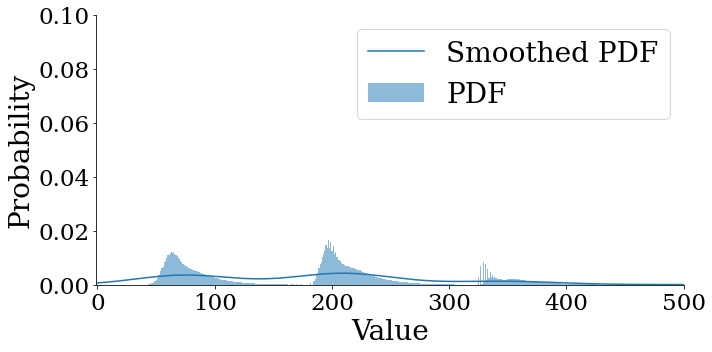

DTMC for exp  E: 184.23834164489273 , variance: 10615.649931455135 , VaR: 339 , CVaR: 383.45795537928973 , Threshold: 0.09915076941016547
Reading file: tests/experiments/drones_15/drones_15_distr_dtmc_cvar_c51.csv
1106
0.9999999999999964 True
max p: 0.01662716923989321


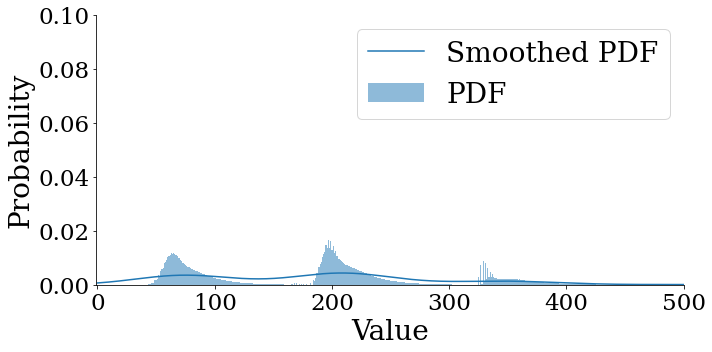

DTMC for cvar  E: 184.8151287588587 , variance: 10491.5327846498 , VaR: 339 , CVaR: 381.88057830633073 , Threshold: 0.09830812127520146
---DVI---
Reading file: tests/experiments/drones_15/drones_15_distr_exp_c51.csv
201
0.9999999999999988 True
max p: 0.024048424699573932


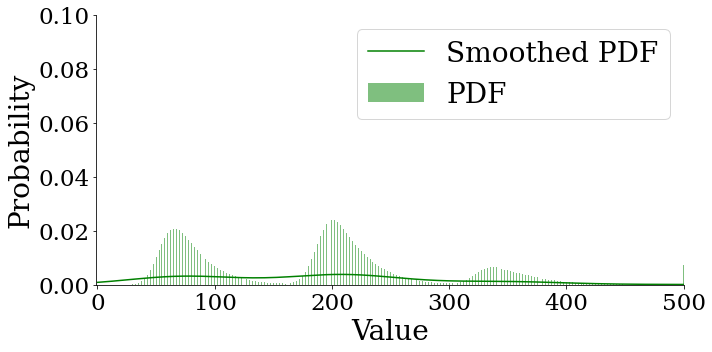

Risk neutral DVI: E:183.96015919319944, variance:10525.748564473175, VaR:340.0, CVaR:381.97400434966926, threshold:0.10528686096920162
Reading file: tests/experiments/drones_15/drones_15_distr_cvar_c51.csv
100
1.0 True
max p: 0.5974354658203123


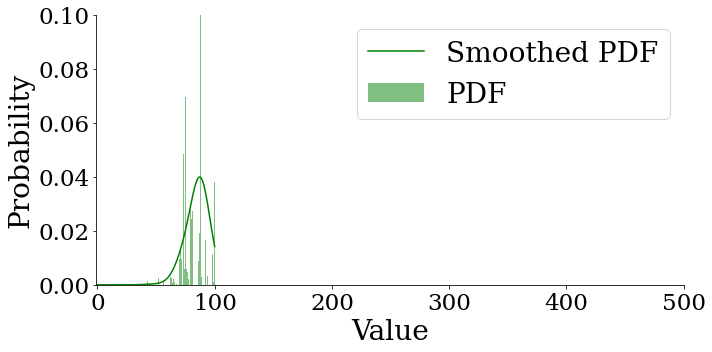

Risk sensitive DVI: E:85.28002082495115, variance:55.906117136665934, VaR:90.0, CVaR:96.21042062988282, threshold:0


In [28]:
# Cvar alpha parameter
# 0.7 default
# 0.8 for ds_treasure, betting_game, grid 150
# 0.9 for SSP comparison benchmarks and drones
alpha=0.9
# threshold value when computing 
# the probability of a cost higher than the set threshold
# this parameter is to be varied based on the benchmark
thresh=340
algs= ['exp', 'cvar'] # ['vi', 'exp', 'cvar','dtmc'] 
show_graph = True # show the distribution graph
appendix  = '' # appendix if applicable, add an '_' before the appendix set with the running script

print('---DTMC---')
for idx, alg_type in enumerate(algs):
    _,_,_,_ = dtmc_compute(idx, appendix, experiment_name, rep_type, alpha=alpha, show_graph=show_graph, debug=True, print_metrics=True)
print('---DVI---')
if 'exp' in algs or 'dtmc' in algs:
    _,_,_ = exp_compute(idx, appendix, experiment_name, rep_type, alpha=alpha, show_graph=show_graph, debug=True, print_metrics=True)
if 'cvar' in algs:
    _,_,_ = cvar_compute(idx, appendix, experiment_name, rep_type, alpha=alpha, show_graph=show_graph, debug=True, print_metrics=True)

##### Running varying atoms
Print the distributional metrics for :

* metrics for risk-neutral DVI distributions 
* metrics for DTMC distributions induced from risk-neutral DVI policies

In [72]:
# apdx = ['_1','_10', '_25', '_50', '_75', '_100']
apdx = ['_1','_10', '_25', '_50', '_75', '_100','_500', '_1000', '_5000']
rep_type = 'c51' # c51 or qr
metrics_dtmc = np.zeros([len(apdx), num_metrics])
metrics_e = np.zeros([len(apdx), num_metrics])
metrics_c = np.zeros([len(apdx), num_metrics])
print_metrics=True

In [73]:
for idx, apd in enumerate(apdx):
    if 'c51' in rep_type and idx > 5:
        continue
    _,_, metrics_e[idx] = exp_compute(idx, apd, experiment_name, rep_type, alpha=alpha, show_graph=False, debug=False, print_metrics=print_metrics)

Risk neutral DVI: E:61.9213833160332, variance:2357.8806198322054, VaR:100.0, CVaR:100.0, threshold:0.6192138331603317
Risk neutral DVI: E:61.92138331603321, variance:901.4685169114827, VaR:100.0, CVaR:100.0, threshold:0.837291368050781
Risk neutral DVI: E:61.9213833160332, variance:888.7021126906427, VaR:100.0, CVaR:100.0, threshold:0.7964032201054685
Risk neutral DVI: E:61.9213833160332, variance:887.0783985970139, VaR:100.0, CVaR:100.0, threshold:0.8008584379179685
Risk neutral DVI: E:61.921383316033186, variance:886.9737771025054, VaR:100.0, CVaR:100.0, threshold:0.7995124471562496
Risk neutral DVI: E:61.921383316033214, variance:886.7577351539885, VaR:100.0, CVaR:100.0, threshold:0.8006405697539063


In [74]:
alg_type = 'exp'
print('DTMC distribution for alg:', alg_type)
for idx, apd in enumerate(apdx):
    if 'c51' in rep_type and idx > 5:
        continue
    _,_, metrics_dtmc[idx],_ = dtmc_compute(idx, apd, experiment_name, rep_type, alpha=alpha, show_graph=False, debug=False, print_metrics=print_metrics)

DTMC distribution for alg: exp
DTMC: E: 61.921383316033214 , variance: 886.7577351539885 , VaR: 100 , CVaR: 100.0 , Threshold: 0.8006405697539061
DTMC: E: 61.921383316033214 , variance: 886.7577351539885 , VaR: 100 , CVaR: 100.0 , Threshold: 0.8006405697539061
DTMC: E: 61.921383316033214 , variance: 886.7577351539885 , VaR: 100 , CVaR: 100.0 , Threshold: 0.8006405697539061
DTMC: E: 61.921383316033214 , variance: 886.7577351539885 , VaR: 100 , CVaR: 100.0 , Threshold: 0.8006405697539061
DTMC: E: 61.921383316033214 , variance: 886.7577351539885 , VaR: 100 , CVaR: 100.0 , Threshold: 0.8006405697539061
DTMC: E: 61.921383316033214 , variance: 886.7577351539885 , VaR: 100 , CVaR: 100.0 , Threshold: 0.8006405697539061


##### Running varying slack variable atoms
Print the distributional metrics for :

* metrics for risk-sensitive DVI distributions 
* metrics for DTMC distributions induced from risk-sensitive DVI policies

In [75]:
if 'c51' in rep_type:
    apdx =['_0', '_10', '_25', '_50', '_75', '_100']
for idx, apd in enumerate(apdx):
    if idx > 5:
        continue
    _,_, metrics_c[idx] = cvar_compute(idx, apd, experiment_name, rep_type, alpha=alpha, show_graph=False, debug=False, print_metrics=print_metrics)

Risk sensitive DVI: E:61.92138331603321, variance:886.7577351539885, VaR:100.0, CVaR:100.0, threshold:0.8006405697539063
Risk sensitive DVI: E:87.79384944140624, variance:32.959813345628994, VaR:90.0, CVaR:94.6789744140625, threshold:0.9999999999999998
Risk sensitive DVI: E:85.28002082495115, variance:55.90611713666594, VaR:90.0, CVaR:96.21042062988282, threshold:0.9999999999999999
Risk sensitive DVI: E:85.28002082495115, variance:55.90611713666594, VaR:90.0, CVaR:96.21042062988282, threshold:0.9999999999999999
Risk sensitive DVI: E:85.28002082495115, variance:55.90611713666594, VaR:90.0, CVaR:96.21042062988282, threshold:0.9999999999999999
Risk sensitive DVI: E:85.28002082495115, variance:55.90611713666594, VaR:90.0, CVaR:96.21042062988282, threshold:0.9999999999999999


In [76]:
alg_type = 'cvar'
print('DTMC distribution for alg:', alg_type)
for idx, apd in enumerate(apdx):
    if 'c51' in rep_type and idx > 5:
        continue
    _,_, metrics_dtmc[idx],_ = dtmc_compute(idx, apd, experiment_name, rep_type, alpha=alpha, show_graph=False, debug=False, print_metrics=print_metrics)

DTMC distribution for alg: cvar
DTMC: E: 61.921383316033214 , variance: 886.7577351539885 , VaR: 100 , CVaR: 100.0 , Threshold: 0.8006405697539061
DTMC: E: 87.79384944140625 , variance: 32.95981334562899 , VaR: 90 , CVaR: 94.6789744140625 , Threshold: 0.9999999999999998
DTMC: E: 85.28002082495117 , variance: 55.906117136665934 , VaR: 90 , CVaR: 96.2104206298828 , Threshold: 0.9999999999999998
DTMC: E: 85.28002082495117 , variance: 55.906117136665934 , VaR: 90 , CVaR: 96.21042062988282 , Threshold: 0.9999999999999998
DTMC: E: 85.28002082495117 , variance: 55.906117136665934 , VaR: 90 , CVaR: 96.21042062988282 , Threshold: 0.9999999999999998
DTMC: E: 85.28002082495115 , variance: 55.90611713666593 , VaR: 90 , CVaR: 96.21042062988282 , Threshold: 0.9999999999999999


##### Distributional distance between DTMC and DVI distributions

This goes through the experiment which varies the distributional approximation for either risk neutral ('exp') or risk-sensitive DVI ('cvar').

* `l2` : denotes the Cramer distributional distance
* `w1`: denotes 1-Wasserstein distributional distance


In [80]:

apdx = ['_1','_10', '_25', '_50', '_75', '_100','_500', '_1000', '_5000']

alg_type = 'exp' # Set to 'exp' or 'cvar'
rep_types = [ 'c51', 'qr'] # c51 or qr
experiment_name='betting_g'

metrics_dtmc = np.zeros([len(apdx), num_metrics])
metrics_e = np.zeros([len(apdx), num_metrics])
metrics_c = np.zeros([len(apdx), num_metrics])
print_metrics=True

distance = np.zeros([len(apdx)])
distance2 =np.zeros([len(apdx)])

if 'cvar' in alg_type:
    apdx = [el+'_va' for el in apdx]

for rep_type in rep_types:
    print(rep_type)
    if 'c51' in rep_type:
        print('Number of atoms:', apdx[:6])
        print('----- l2-----')
    elif 'qr' in rep_type:
        print('Number of atoms:',apdx)
        print('----- l2-----')

    for idx, apd in enumerate(apdx):
        
        if 'c51' in rep_type and idx > 5:
            continue
        rx, rp, metrics_dtmc[idx],_ = dtmc_compute(idx,  apd, experiment_name, rep_type, alpha=alpha, show_graph=False, debug=False)

        if 'exp' in alg_type:
            rx_v, rp_v, metrics_e[idx] = exp_compute(idx, apd, experiment_name, rep_type, alpha=alpha, show_graph=False, debug=False)
        else:
            rx_v, rp_v, metrics_c[idx] = cvar_compute(idx, apd, experiment_name, rep_type, alpha=alpha, show_graph=False, debug=False)

        if 'c51' in rep_type:
            distance[idx] = l2(rx, rx_v, rp, rp_v, debug=False)

        elif 'qr' in rep_type:
            distance2[idx] = scipy.stats.wasserstein_distance(rx, rx_v, rp, rp_v)
            distance[idx] = l2(rx, rx_v, rp, rp_v, debug=False)
            
        print(distance[idx])
    
    # Uncomment to print wasserstein p=1 distance for Quantile representation
    # if 'qr' in rep_type:
    #     print('----- w1-----')
    #     for idx in range(len(apdx)):
    #         print(distance2[idx])

c51
Number of atoms: ['_1', '_10', '_25', '_50', '_75', '_100']
----- l2-----
2.621336724135326
0.3372088602433126
0.15348469666713258
0.062001369828988254
0.08430257655691833
1.7333351416399796e-16
qr
Number of atoms: ['_1', '_10', '_25', '_50', '_75', '_100', '_500', '_1000', '_5000']
----- l2-----
3.735708915046805
0.8458606925217265
0.26592291472234386
0.11258396052321046
0.058187075519962404
0.060143485367470335
0.009836035167883679
0.006045974782232942
0.0009023606658701151


#### Example figure

In [16]:
# Convert a generic distribution to a categorical distribution
def get_support(arr_p, rx, rz, debug=False):
    atoms = len(rz)
    dtmc_atoms = len(rx)
    m = np.zeros([atoms])
    b = 0
    vmin = rz[0]; vmax= rz[-1]
    delta_z = abs(rz[1] - rz[0])
    if debug:
        print(f"m:{m}\n b:{b}, atoms:{atoms}, vmin:{vmin}, vmax:{vmax}, delta_z:{delta_z}\n rz: {rz}")
        print(arr_p)
        print("rx: ", rx)
    
    assert delta_z >0 and atoms >0 or dtmc_atoms >0

    for j in range(dtmc_atoms):
        temp = max(vmin, min(vmax, rx[j]))
        b = (temp - vmin) / delta_z
        l= int(math.floor(b)); u= int(math.ceil(b));
    
        if ( l- u != 0):
                m[l] += arr_p[j] * (u -b);
                m[u] += arr_p[j] * (b-l);
        else:
                m[l] += arr_p[j];
    
    return m

def plot_distr(rx_c, rp_c, z_c, apdx, experiment_name, rep_type, show_graph=True, debug=True, print_metrics=False, elements=False, figure=None, smooth =False, alpha=0.7, save_graphs=False):
    n = np.max(np.where(rp_c > 1e-6))
    rx_c = rx_c[0:n+1]
    rp_c = rp_c[0:n+1]
    z_c = z_c[0:n+1]
    if debug:
        print(n)
        print(np.sum(rp_c), np.allclose(np.sum(rp_c), 1))
        print("max p:", np.max(rp_c))
    
    if show_graph:
        distr_c = scipy.stats.rv_discrete(values=(z_c, rp_c))
        # h = plt.bar(rx_c, rp_c, alpha=0.5)
        fig=plt.figure(figsize=fig_size)
            
        if not elements:
            h = plt.bar(z_c, rp_c, alpha=0.5, color='g', label='PDF')
        else:
            h = plt.bar(z_c, rp_c, alpha=0.8, width=0.3, color='g')
            plt.plot(z_c, rp_c, 'go')
            if not smooth:
                plt.bar(figure[0], figure[1].pmf(figure[0]), width=0.98, color='k', alpha=0.3, linewidth=0,label='PDF')
            else:
                # 30`0 represents number of points to make between T.min and T.max
                xnew = np.linspace(6, figure[0].max(), 300) 

                spl = make_interp_spline(figure[0], figure[1].pmf(figure[0]), k=3)  # type: BSpline
                power_smooth = spl(xnew)

                plt.plot(xnew, power_smooth, color='k', alpha=0.5, label='Smoothed PDF')
                plt.fill_between(xnew, power_smooth, 0, color='gray', alpha=.3)
        kernel = scipy.stats.gaussian_kde(z_c, weights=rp_c)
        if 'qr' in rep_type:
            range = z_c
        else:
            range = np.arange(0, z_c[-1]+z_c[1], z_c[1]) 
        
        if not elements:
            plt.plot(range, kernel(range), color='g', label='Smoothed PDF')
        plt.xlim([xmin,xmax])
        plt.ylim([0,ymax])

        if not elements:
            plt.legend(loc='upper right', fontsize=graphsize-10)
        plt.tick_params(axis='both', which='major', labelsize=graphsize-15)
        plt.ticklabel_format(axis='both')
        plt.xlabel('Value', fontsize=graphsize-10)
        plt.ylabel('Probability', fontsize=graphsize-10)
        # plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
        plt.tight_layout()
        plt.show()
        # plt.fill_between(range, kernel(range))

        if save_graphs:
            if not smooth:
                print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_cvar_fake_'+rep_type+apdx+".png")
                fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_cvar_fake_'+rep_type+apdx+".png", transparent=True, dpi=400)
            else:
                print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_cvar_fake_'+rep_type+apdx+'_smooth'+".png")
                fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_cvar_fake_'+rep_type+apdx+'_smooth'+".png", transparent=True, dpi=400)

    var_cvar = VaR(z_c, rp_c, alpha)
    if debug or print_metrics:
        print(f"E:{weighted_mean(z_c, rp_c)}, variance:{variance(z_c, rp_c)}, VaR:{var_cvar}, CVaR:{CVaR(z_c, rp_c, var_cvar, alpha)}, threshold:{prob_threshold(z_c, rp_c, thresh)}")
    return z_c, rp_c, np.array([weighted_mean(z_c, rp_c), variance(z_c, rp_c), var_cvar, CVaR(z_c, rp_c, var_cvar, alpha), prob_threshold(z_c, rp_c, thresh)])

---DTMC---


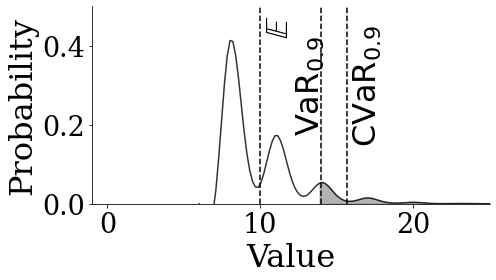

DTMC for cvar  E: 9.990613323385194 , variance: 6.331485249234092 , VaR: 14 , CVaR: 15.664663815478857 , Threshold: 6.024641900436632e-05
---DVI---


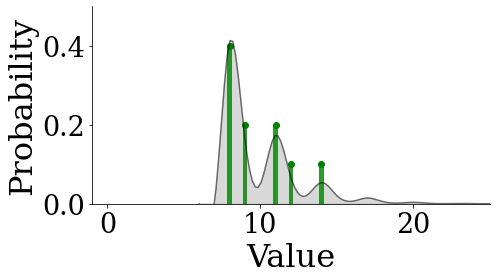

Risk sensitive DVI: E:9.8, variance:3.96, VaR:12.0, CVaR:14.0, threshold:0


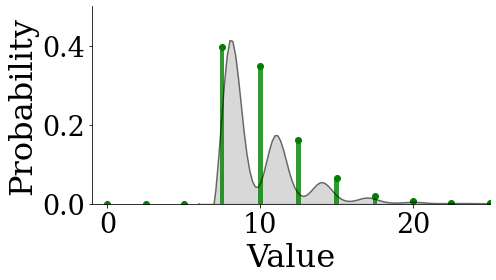

E:9.989478979408885, variance:7.418605023072939, VaR:12.5, CVaR:15.923790024181617, threshold:0


In [17]:

xmax = 25
ymax = 0.5
algs=['cvar'] #['vi', 'exp', 'cvar']
smoothed= True
graphsize = 42
alpha=0.9
fig_size= (7,4)

print('---DTMC---')
for idx, alg_type in enumerate(algs):
    rx,rp,_,dist = dtmc_compute(idx, '_ex_fig_2', 'test', 'c51', alpha=alpha, show_graph=True, debug=False, print_metrics=True, shaded=True, y_padding=0.28)

print('---DVI---')
if 'exp' in algs:
    _,_,_ = exp_compute(idx, '_ex_fig_2', 'test', 'c51', alpha=alpha, show_graph=True, debug=False, print_metrics=True, elements=True, figure=(rx, dist), smooth=smoothed)
    _,_,_ = exp_compute(idx, '_ex_fig_2', 'test', 'qr', alpha=alpha, show_graph=True, debug=False, print_metrics=True, elements=True, figure=(rx, dist), smooth=smoothed)
else:
    rz,_,_ = cvar_compute(idx, '_ex_fig_2', 'test', 'c51', alpha=alpha, show_graph=False, debug=False, print_metrics=False, elements=True, figure=(rx, dist), smooth=smoothed)
    _,_,_ = cvar_compute(idx, '_ex_fig_2', 'test', 'qr', alpha=alpha, show_graph=True, debug=False, print_metrics=True, elements=True, figure=(rx, dist), smooth=smoothed)

m = get_support(rp, rx, rz)

_,_,_ = plot_distr(rx, m, rz, '_ex_fig_2', 'test', 'c51', alpha=alpha, show_graph=True, debug=False, print_metrics=True, elements=True, figure=(rx, dist), smooth=smoothed)

